<a href="https://colab.research.google.com/github/Crasht608/Cotton-disease-Prediction/blob/main/Cotton_Disease_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"]= "/content" #folder


In [ ]:
!kaggle datasets download -d krupalisurani/cotton-disease-detection

 90% 133M/148M [00:01<00:00, 145MB/s]
100% 148M/148M [00:01<00:00, 129MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  cotton-disease-detection.zip
  inflating: Cotton Disease/test/diseased cotton/test_diseased_1.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_10.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_11.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_12.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_13.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_14.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_15.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_16.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_17.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_18.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_19.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_2.jpg  
  inflating: Cotton Disease/test/diseased cotton/test_diseased_20.jpg  
  inflating: Cotton Disease

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

In [ ]:
train_dir = "/content/Cotton Disease/train"
validation_dir = "/content/Cotton Disease/test"

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1951 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle = True,
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMG_SIZE)

Found 106 files belonging to 2 classes.


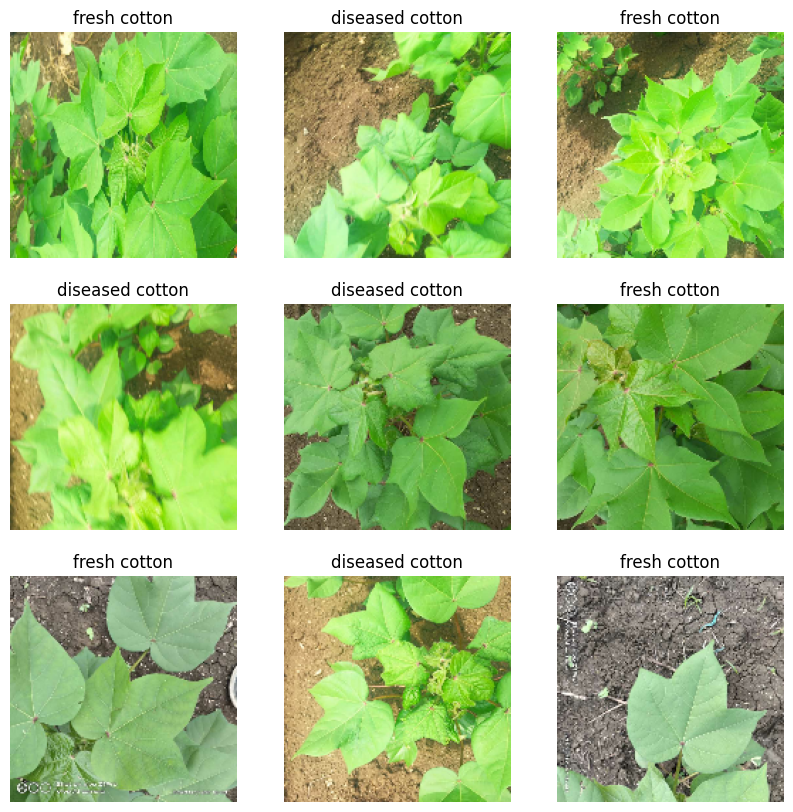

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches //5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

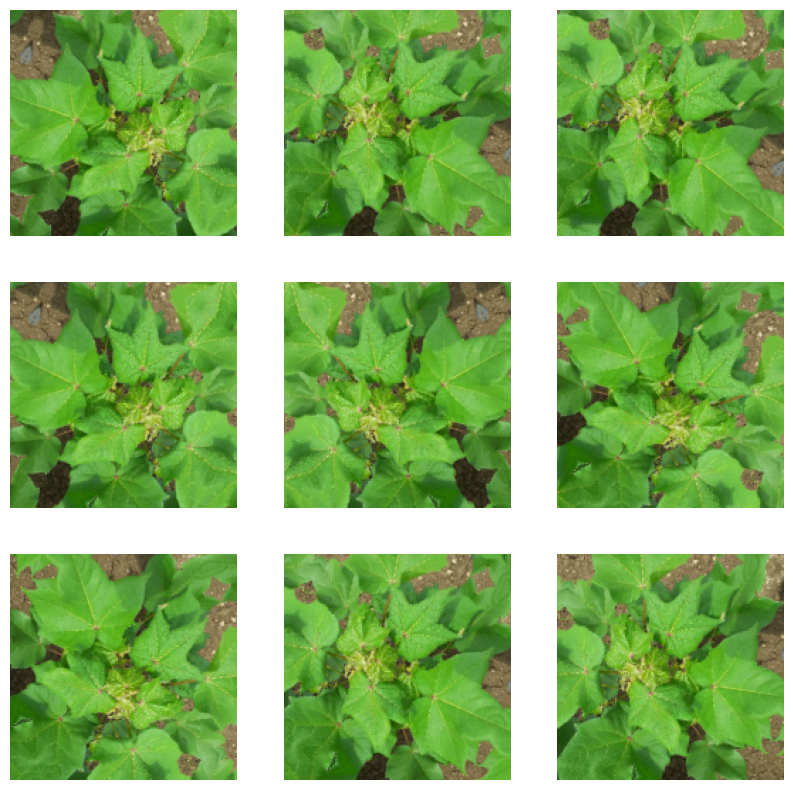

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model Inception V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

219055592/219055592 [==============================] - 6s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1536)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 79, 79, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 79, 79, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 79, 79, 32)           0         ['batch_norm

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, 3, 3, 1536)        54336736  
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

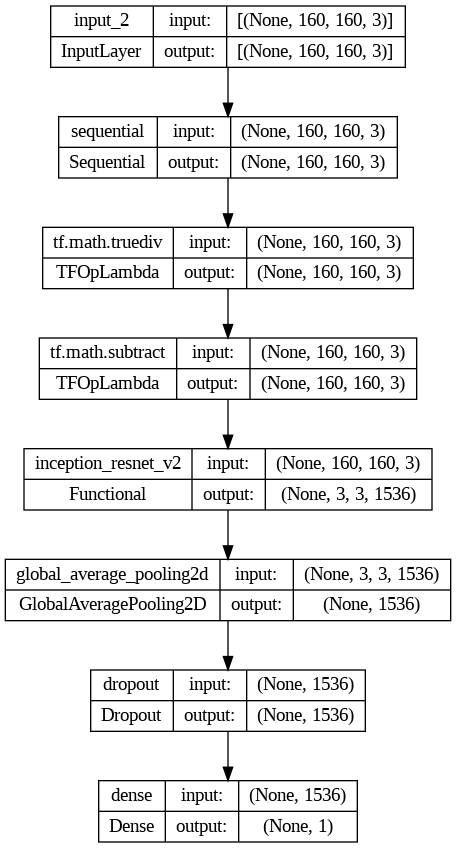

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs =20

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 17s 3s/step - loss: 1.0158 - accuracy: 0.5000


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.02
initial accuracy: 0.50


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
61/61 [==============================] - 259s 4s/step - loss: 0.8417 - accuracy: 0.4828 - val_loss: 0.7473 - val_accuracy: 0.4717
Epoch 2/20
61/61 [==============================] - 250s 4s/step - loss: 0.7403 - accuracy: 0.5454 - val_loss: 0.7043 - val_accuracy: 0.5283
Epoch 3/20
61/61 [==============================] - 236s 4s/step - loss: 0.6896 - accuracy: 0.5946 - val_loss: 0.6694 - val_accuracy: 0.6132
Epoch 4/20
61/61 [==============================] - 236s 4s/step - loss: 0.6674 - accuracy: 0.6320 - val_loss: 0.6486 - val_accuracy: 0.6792
Epoch 5/20
61/61 [==============================] - 234s 4s/step - loss: 0.6388 - accuracy: 0.6540 - val_loss: 0.6256 - val_accuracy: 0.6981
Epoch 6/20
61/61 [==============================] - 236s 4s/step - loss: 0.6062 - accuracy: 0.6832 - val_loss: 0.6019 - val_accuracy: 0.7264
Epoch 7/20
61/61 [==============================] - 236s 4s/step - loss: 0.5943 - accuracy: 0.6981 - val_loss: 0.5806 - val_accuracy: 0.7736
Epoch 8/20
61

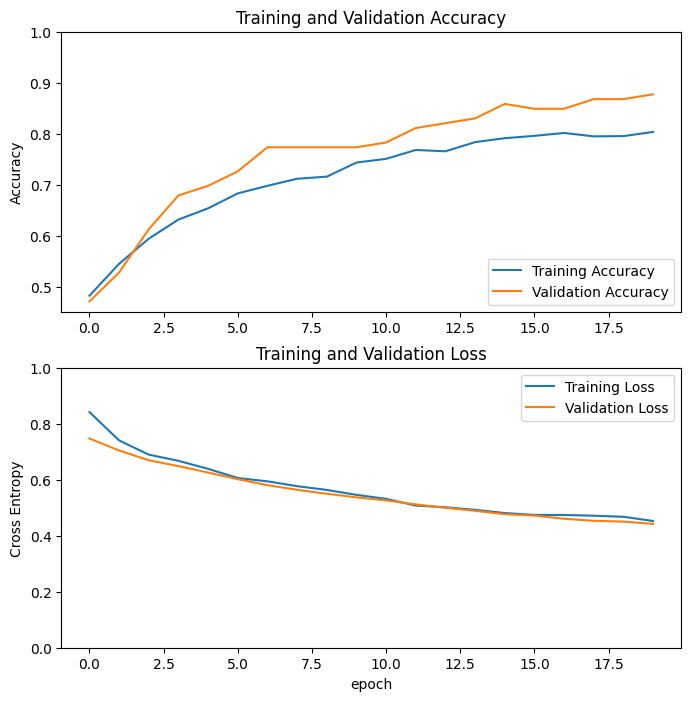

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 inception_resnet_v2 (Funct  (None, 3, 3, 1536)        54336736  
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

426

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

#New Code

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2
from keras import Model,layers

In [ ]:
model = InceptionResNetV2(include_top=False,weights='imagenet')

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
import tensorflow as tf

In [ ]:
Train_dir = '/content/Cotton Disease/train'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('/content/Cotton Disease/train',target_size=(96,96),shuffle=True,batch_size=64,class_mode='binary')

Found 1951 images belonging to 2 classes.


In [ ]:
VAL_DIR='/content/Cotton Disease/val'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(VAL_DIR,target_size=(96,96),batch_size=64,shuffle=True,class_mode='binary')

Found 253 images belonging to 2 classes.


In [ ]:
from keras import models

In [ ]:
classifier = models.Sequential()

In [ ]:
classifier.add(model)

In [ ]:
classifier.add(layers.GlobalAveragePooling2D())

In [ ]:
classifier.add(layers.Dense(units = 1,activation='sigmoid'))

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 54338273 (207.28 MB)
Trainable params: 54277729 (207.05 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [ ]:
classifier.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss='binary_crossentropy',metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
h1 = classifier.fit(train_generator,epochs=20,batch_size=64,validation_data=test_generator,verbose=1)

Epoch 1/20
31/31 [==============================] - 411s 11s/step - loss: 0.5189 - binary_accuracy: 0.7734 - auc: 0.8305 - precision: 0.8285 - recall: 0.6038 - val_loss: 0.5798 - val_binary_accuracy: 0.6285 - val_auc: 0.8642 - val_precision: 0.5856 - val_recall: 0.9848
Epoch 2/20
31/31 [==============================] - 330s 11s/step - loss: 0.3081 - binary_accuracy: 0.8801 - auc: 0.9425 - precision: 0.8681 - recall: 0.8538 - val_loss: 0.4772 - val_binary_accuracy: 0.7154 - val_auc: 0.9426 - val_precision: 0.6500 - val_recall: 0.9848
Epoch 3/20
31/31 [==============================] - 330s 11s/step - loss: 0.2164 - binary_accuracy: 0.9149 - auc: 0.9714 - precision: 0.9089 - recall: 0.8939 - val_loss: 0.3701 - val_binary_accuracy: 0.8419 - val_auc: 0.9657 - val_precision: 0.7805 - val_recall: 0.9697
Epoch 4/20
31/31 [==============================] - 330s 11s/step - loss: 0.1854 - binary_accuracy: 0.9288 - auc: 0.9786 - precision: 0.9287 - recall: 0.9057 - val_loss: 0.3361 - val_binary_

In [ ]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
import matplotlib
colorname = []
colorid = []
for name, hex in matplotlib.colors.cnames.items():
    colorname.append(name)
    colorid.append(hex)

In [ ]:
zippedcolors = list(zip(colorname, colorid))
zippedcolors = sorted(zippedcolors, key=lambda x: x[1])
print(zippedcolors)

[('black', '#000000'), ('navy', '#000080'), ('darkblue', '#00008B'), ('mediumblue', '#0000CD'), ('blue', '#0000FF'), ('darkgreen', '#006400'), ('green', '#008000'), ('teal', '#008080'), ('darkcyan', '#008B8B'), ('deepskyblue', '#00BFFF'), ('darkturquoise', '#00CED1'), ('mediumspringgreen', '#00FA9A'), ('lime', '#00FF00'), ('springgreen', '#00FF7F'), ('aqua', '#00FFFF'), ('cyan', '#00FFFF'), ('midnightblue', '#191970'), ('dodgerblue', '#1E90FF'), ('lightseagreen', '#20B2AA'), ('forestgreen', '#228B22'), ('seagreen', '#2E8B57'), ('darkslategray', '#2F4F4F'), ('darkslategrey', '#2F4F4F'), ('limegreen', '#32CD32'), ('mediumseagreen', '#3CB371'), ('turquoise', '#40E0D0'), ('royalblue', '#4169E1'), ('steelblue', '#4682B4'), ('darkslateblue', '#483D8B'), ('mediumturquoise', '#48D1CC'), ('indigo', '#4B0082'), ('darkolivegreen', '#556B2F'), ('cadetblue', '#5F9EA0'), ('cornflowerblue', '#6495ED'), ('rebeccapurple', '#663399'), ('mediumaquamarine', '#66CDAA'), ('dimgray', '#696969'), ('dimgrey', 

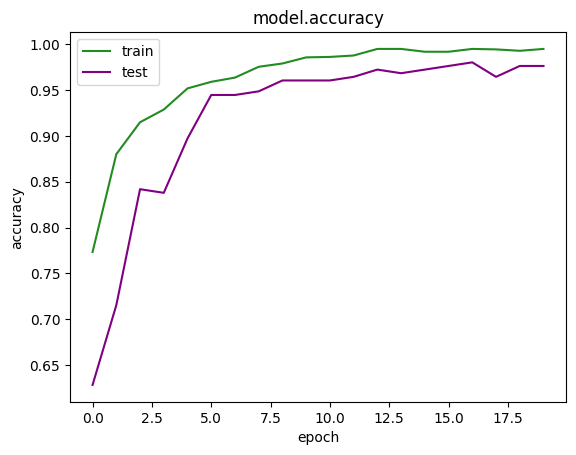

In [ ]:
plt.plot(h1.history['binary_accuracy'],color = 'forestgreen')
plt.plot(h1.history['val_binary_accuracy'],color = 'purple')
plt.title('model.accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')

plt.savefig('acc.png')
plt.show()

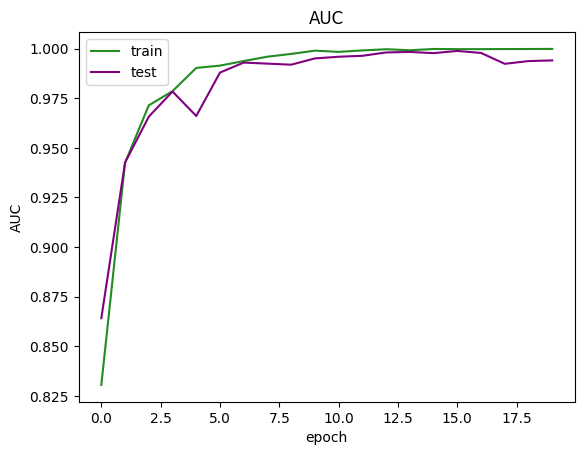

In [ ]:
plt.plot(h1.history['auc'],color = 'forestgreen')
plt.plot(h1.history['val_auc'], color = 'purple')
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.savefig('auc.png')
plt.show()

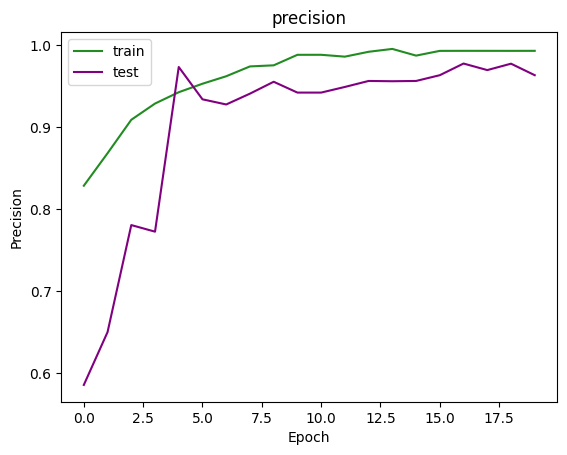

In [ ]:
plt.plot(h1.history['precision'],color = 'forestgreen')
plt.plot(h1.history['val_precision'],color = 'purple')
plt.title('precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.savefig('prec.png')
plt.show()

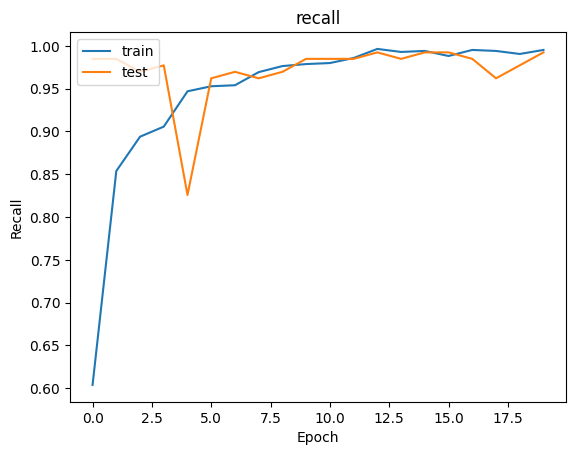

In [ ]:
plt.plot(h1.history['recall'])
plt.plot(h1.history['val_recall'])
plt.title('recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

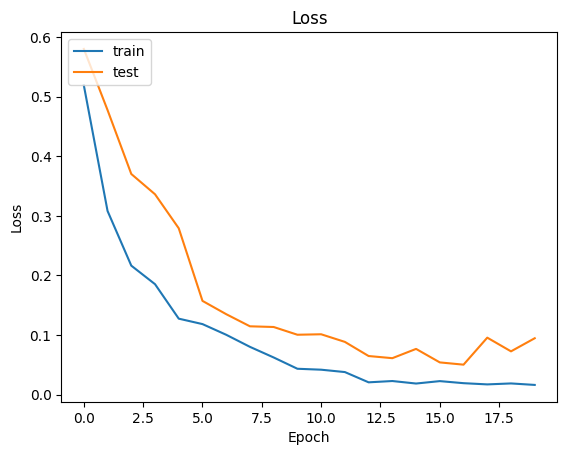

In [ ]:
plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()